In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
#if not os.path.exists(data_path+'training_data/'):
 #   os.mkdir(data_path+'training_data/')
  #  with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
   #     zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

For this demonstration, we will constrain our search to frogs in the Greater Sydney area found between the start of 2015 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

In [3]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner

bbox = (min_lon, min_lat, max_lon, max_lat)
min_lon1, min_lat1 = (144.8, -38.5)  # Lower-left corner
max_lon1, max_lat1 = (145.8, -37.5)  # Upper-right corner
bbox1 = (min_lon1, min_lat1, max_lon1, max_lat1)

min_lon2, min_lat2 = (150.7, -33.5)  # Lower-left corner
max_lon2, max_lat2 = (151.7, -32.5)  # Upper-right corner
bbox2 = (min_lon2, min_lat2, max_lon2, max_lat2)

min_lon3, min_lat3 = (152.6, -29.0)  # Lower-left corner
max_lon3, max_lat3 = (153.6, -28.0)  # Upper-right corner
bbox3 = (min_lon3, min_lat3, max_lon3, max_lat3)

min_lon4, min_lat4 = (145.0, -17.7)  # Lower-left corner
max_lon4, max_lat4 = (146.0, -16.7)  # Upper-right corner
bbox4 = (min_lon4, min_lat4, max_lon4, max_lat4)

min_lon5, min_lat5 = (115.7, -32.5)  # Lower-left corner
max_lon5, max_lat5 = (116.7, -31.5)  # Upper-right corner
bbox5 = (min_lon5, min_lat5, max_lon5, max_lat5)

# Load in data
#all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
boxes = [bbox1,bbox2,bbox3,bbox4,bbox5]
all_frog_data = get_frogs('occurrence.txt', year_range=(2015, 2019), bbox=bbox)
#all_frog_data[('species'=='Litoria Fallax')]

#get_frogs('occurrence.txt', year_range=(2015, 2019), bbox=i

In [11]:
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax
...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera


#### Spatial sampling

While we have restricted our analysis to Greater Sydney for this demonstration,  you are encouraged to explore different areas to assist in creating a SDM that is representative of the habitat of litoria fallax. You could even use the entire training set, but keep in mind that loading in large areas may be quite computationally expensive. We recommend loading data in chunks that are a similar size to the bounding box we defined above.

#### Temporal sampling

Another area that may assist you in developing your SDM is the time dimension of the data. Each occurrence has an "eventDate" attribute, and the terraclimate data is taken monthly. You may want to consider whether more closely matching occurrences to timely data will improve your model. Another idea is to pool the data into larger time chunks like we have done in this notebook. This could involve extending our approach of binning the data in 5 year intervals to include occurrence data for 2010-2015, 2005-2009, etc. Either approach would allow you to utilise more of the training data which could greatly assist your SDM training.

### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

In [4]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of the area. Here, only two of the five Australian species are present: crinia signifera, the common eastern froglet, and litoria fallax, the eastern dwarf tree frog.

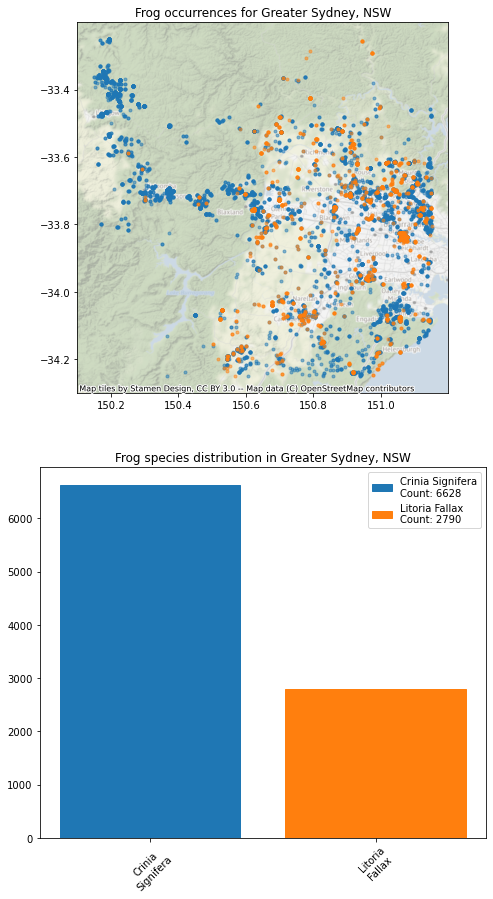

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

One method of addressing the sampling bias inherent in the database is to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

For this notebook, we will use the other species, crinia signifera - the common eastern froglet, as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax (i.e. is crinia signifera).

In [14]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax,1
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera,0
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax,1
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax,1
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera,0
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax,1
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax,1
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera,0


#### Class Balancing

Another bias shown in the above visualisations is the class imbalance. To handle this, we will down-sample the absence points so that their numbers match that of the target species. Note that this is quite a naive approach as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. This may not be ideal, as these isolated occurrences are often the most important data points available for frog conservationists. Developing a smarter sampling method may be a worthwhile pursuit when considering ways to improve your model.

The barcharts below show the response variable before and after the classes have been balanced.

Text(0.5, 1.0, 'Balanced training set')

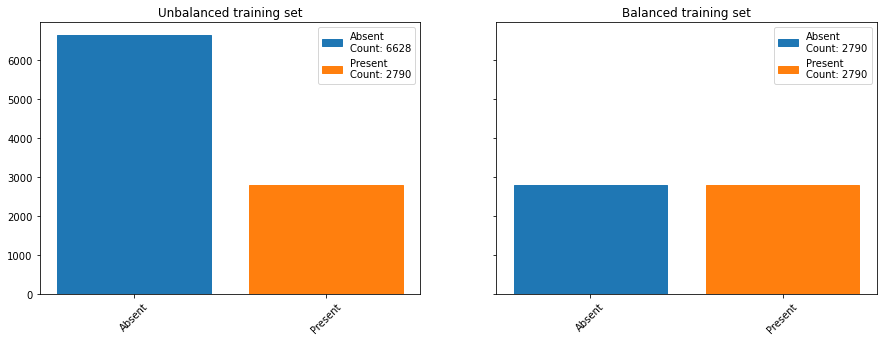

In [15]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus== 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [5]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

Reference evapotranspiration (ASCE Penman-Montieth), Runoff, Actual Evapotranspiration, Climate Water Deficit, Soil Moisture, Snow Water Equivalent, Palmer Drought Severity Index, Vapor pressure deficit


In [6]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2012-01-01','2020-12-31')

# Measurements to take: primary + secondary variables
assets=['tmax', 'tmin', 'ppt', 'srad','vap','ws','aet','def','pet','q','vpd']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean','srad_mean','vap_mean','ws_mean',
          'aet_mean','def_mean','pet_mean','q_mean','vpd_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

#weather_data = get_terraclimate(bbox5, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
#display(weather_data.band.values)

In [26]:
weather_data.to_netcdf('weather_data5.nc')

In [47]:
weather_data4 = xr.open_dataset('weather_data4.nc')
weather_data5 = xr.open_dataset('weather_data5.nc')

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

## Join weather onto frog? 

In [7]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
#model_data = join_frogs(frog_data, combine_45)
#model_data.head()

## Model Building

### Model Training


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df = pd.read_csv('climate_frog1220.csv')
X = df[['aet_mean', 'def_mean', 'pet_mean', 'ppt_mean', 'q_mean', 'srad_mean', 
        'tmax_mean', 'tmin_mean', 'vap_mean', 'vpd_mean','ws_mean']]
y = df['occurrenceStatus']
# Make pipeline with default solver and l2 penalty
pipe2 = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression(random_state = 0, C = 0.01))])
# Fit on train data
clf2 = pipe2.fit(X, y)
# Predict on itself
y_pred_l2 = clf2.predict(X)
print('clf2 score with l2 penalty: ', clf2.score(X,y_pred_l2))

clf2 score with l2 penalty:  1.0


In [9]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
#resultant_image = predict_frogs(weather_data, full_model)

## Submission

Once you are happy with your model, there will come a time to make a submission to the challenge. To make a submission, you will need to use your model to make predictions about the presence of litoria fallax for a set of test coordinates we have provided. The coordinates are found in the 'challenge_1_submission_template.csv' file, and the list of bounding boxes where the points were sampled from can be found separately in the 'challenge_1_test_regions.txt' file. We recommend looping through the regions identified in that file, pulling the TerraClimate data for that region, and extracting the features for each point in the 'test_1_occurrences.csv' file within that regions bounding box. This will minimise the computational requirements.

In [10]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

In [11]:
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [12]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

In [13]:
test_regions

[{'title': 0, 'bbox': (144.8, -38.5, 145.8, -37.5)},
 {'title': 1, 'bbox': (150.7, -33.5, 151.7, -32.5)},
 {'title': 2, 'bbox': (152.6, -29.0, 153.6, -28.0)},
 {'title': 3, 'bbox': (145.0, -17.7, 146.0, -16.7)},
 {'title': 4, 'bbox': (115.7, -32.5, 116.7, -31.5)}]

In [15]:
region.keys()

NameError: name 'region' is not defined

Note: with the TerraClimate parameters we have set, some areas of each region contain nulls. If this is the case, the prediction will return a null, which evaluates to false when we create the binary mask.

In [31]:
type(test_regions[0]['result'])

xarray.core.dataarray.DataArray

In [27]:
test_regions[0]['result']

<xarray.DataArray (y: 24, x: 24)>
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
...
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]])
Coordinates:
  * y        (y) float64 -37.52 -37.56 -37.6 -37.65 ... -38.4 -38.44 -38.48
  * x        (x) float64 144.8 144.9 144.9 144.9 ... 145.6 145.7 145.7 145.8

In [14]:
# Obtain predictor data for each region and get predictor image
for region in test_regions[1:2]:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], clf2) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

Loading data


FSTimeoutError: 

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [ ]:
predictions = pd.DataFrame()

for region in test_regions[1:2]:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [34]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_submission_benchmark1.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
1486,1486,-37.645833,145.104167,0
1487,1487,-37.729167,145.645833,0
1488,1488,-37.770833,145.604167,0
1489,1489,-37.729167,145.229167,0


In [21]:
submission.groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,2116,2116,2116
1,1935,1935,1935


### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to try running this notebook on a region different to Greater Sydney, or even on multiple regions.

Be sure to address some of the assumptions made here, particularly ways to address the sampling bias in the dataset. Our pseudo-absence method was just one idea, you may want to persue another. Another important issue to consider is that of class imbalance. In this notebook, we simply down-sampled the non-target species to match the number of target species. This may not be ideal, as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. Perhaps a method of sampling only from clustered occurrences would address class imbalance while also helping to offset the sampling bias. Just a thought! You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting the frog habitat of the species of interest. Happy frogging!